In [1]:
%matplotlib inline

import os
import sys
from importlib import import_module

import numpy as np
import quantities as pq
import matplotlib.pyplot as plt
from neo.core import AnalogSignal

import sciunit
from neuronunit.models import LEMSModel
from neuronunit import capabilities as cap

OW = os.environ['OPENWORM_HOME']
sys.path.append(os.path.join(OW,'CElegansNeuroML','CElegans','pythonScripts'))
import c302

In [2]:
class MuscleModel(LEMSModel,
                  cap.ProducesMembranePotential):
    """A C. elegans muscle cell model"""

    def __init__(self, 
                 config, 
                 parameter_set, 
                 duration, 
                 dt, 
                 data_reader="UpdatedSpreadsheetDataReader",
                 verbose=False,
                 param_overrides={},
                 config_package="",
                 config_param_overrides={},
                 name=None, 
                 backend='jNeuroML', 
                 attrs=None):
        
        if config_package:
            c302_config = import_module('c302.%s.c302_%s' % (config_package, config))
        else:
            c302_config = import_module('c302.c302_%s' % config)
        
        root = c302.__path__[0]
        cells, cells_to_stimulate, params, muscles = c302_config.setup(
                                parameter_set, 
                                data_reader=data_reader,
                                generate=True,
                                duration=duration, 
                                dt=dt,
                                target_directory=os.path.join(root,'examples'),
                                verbose=verbose,
                                param_overrides=param_overrides,
                                config_param_overrides=config_param_overrides)
    
        LEMS_file_path = os.path.join(root,'examples','LEMS_c302_%s_%s.xml'%(parameter_set,config))
        super().__init__(LEMS_file_path,name=name,backend=backend,attrs=attrs)

    def get_membrane_potential(self, cell='GenericMuscleCell', **run_params):
        """Gets membrane potential of either the neuron or the muscle cell"""
        self.run(**run_params)
        for rkey in self.results.keys():
            if '%s/v'%cell in rkey:
                v = np.array(self.results[rkey])
        t = np.array(self.results['t'])
        dt = (t[1]-t[0])*pq.s # Time per sample in seconds.
        vm = AnalogSignal(v,units=pq.V,sampling_rate=1.0/dt).rescale('mV')
        return vm 
        
    def get_membrane_potential_neuron(self, **run_params):
        """Gets membrane potential of the neuron"""
        return self.get_membrane_potential(cell='GenericNeuronCell',**run_params)
    
    def get_membrane_potential_muscle(self, **run_params):
        """Gets membrane potential of the muscle cell"""
        return self.get_membrane_potential(cell='GenericMuscleCell',**run_params)
    
model = MuscleModel('IClampBWM', 'C2', 1000, 0.05, config_package="notebooks.configs")

Set default parameters for C
Set default parameters for C2
Opened file: /Users/rgerkin/Dropbox/dev/openworm/CElegansNeuroML/CElegans/pythonScripts/c302/../../../herm_full_edgelist.csv
Opened file: /Users/rgerkin/Dropbox/dev/openworm/CElegansNeuroML/CElegans/pythonScripts/c302/../../../herm_full_edgelist.csv
c302      >>>  Positioning muscle: MDR01 at (80,-270,80)
c302      >>>  Writing generated network to: /Users/rgerkin/Dropbox/dev/openworm/CElegansNeuroML/CElegans/pythonScripts/c302/examples/c302_C2_IClampBWM.nml
(Re)written network file to: /Users/rgerkin/Dropbox/dev/openworm/CElegansNeuroML/CElegans/pythonScripts/c302/examples/c302_C2_IClampBWM.nml


In [3]:
# A few seconds in jNeuroML
%time neuron_vm = model.get_membrane_potential_neuron()

CPU times: user 671 ms, sys: 24 ms, total: 695 ms
Wall time: 7.26 s


In [4]:
# Used cached results
%time muscle_vm = model.get_membrane_potential_muscle()

CPU times: user 15.7 ms, sys: 3.24 ms, total: 19 ms
Wall time: 26.8 ms


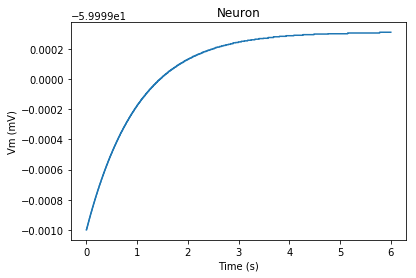

In [5]:
def plot(vm,title):
    plt.plot(vm.times,vm)
    plt.xlabel('Time (s)')
    plt.ylabel('Vm (mV)')
    plt.title(title)
    
plot(neuron_vm,"Neuron")

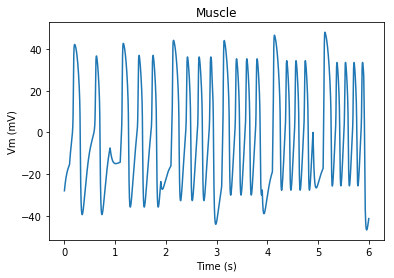

In [6]:
plot(muscle_vm,"Muscle")